# Qiskit Fall Fest 2023

![QFF Logo](images/QFF-logo.png)

## Challenge 5: Dynamic Circuits in Qiskit

## Part 1: Intro To Dynamic Circuits

Qiskit 교육자료인 [Qiskit textbook](https://learn.qiskit.org/course/ch-algorithms/quantum-circuits)에는 다음과 같은 말이 있습니다.
>_"A quantum circuit is a computational routine consisting of coherent quantum operations on qubits ... It is an ordered sequence of quantum gates, measurements and resets, all of which may be conditioned on and use data from the real-time classical computation."_

위 문구를 한국말로 직해하면 다음과 같습니다.
>_양자 회로는 qubit에 대한 일관성 있는 양자 연산으로 구성된 계산 루틴입니다 ... 양자 gate, 측정 및 리셋의 순서대로 나열되는 것이며, 이 모든 것은 실시간 고전 컴퓨팅 계산의 데이터에 따라 조건화되어 사용될 수 있습니다._

인용구의 마지막 문장이 잘 이해가 되지 않으실 수 있습니다. 하지만 그 문장이 dynamic circuit과 직접적으로 연관된 내용입니다. 별다른 수식어 없이 양자 회로라고 말하면 보통 _static_ 양자 회로를 의미합니다. 이전 챌린지에서 봤던 것들은 전부 static 양자 회로입니다. 그러다면 dynamic circuits은 무엇일까요?

지금까지 여러분이 챌린지에서 봐왔던 양자 회로들은 전부 $|0\rangle$ 상태에서 시작하여, 양자 gate들을 가하고, 마지막에 측정을 하는 방식이었습니다. 반면에 **Dynamic circuits**은 양자 회로 중간에 측정을 하여, 그 측정 결과를 바탕으로 후반부 양자 gate 를 어떻게 가할지 결정하는 양자 회로입니다. 이러한 측정 결과는 당연하게도 중첩 같은 성질이 없는 고전적인 값이며, 이러한 고전적인 측정 결과에 따라 이후의 양자 연산을 조건화하는 것을 _classical feedforward_ 라고 합니다.

왜 classical feedforward가 필요할까요? 이러한 feedforward가 필요한 대표적인 예시는 conditional reset이라고 불리는 과정이며 Qiskit에서는 [`reset`](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.reset.html) 연산이 이에 해당 합니다. reset은 non-unitary 연산자로서 이전의 양자 상태가 무슨 상태인지 상관없이 reset 연산을 거치면 그 qubit의 양자 상태는 $|0\rangle$ 상태가 됩니다. 이 reset 연산은 다음과 같은 과정을 통해 이루어집니다. 해당 qubit을 측정한 후에, 측정 결과가 $|0\rangle$이면 아무런 행동을 취하지 않고, 측정 결과가 $|1\rangle$ 이라면 X gate를 가해서 $|0\rangle$ 상태로 만듭니다. 즉, 해당 qubit를 측정하여 $|0\rangle$ 혹은 $|1\rangle$ 상태로 붕괴(collapse)시키고, 만약 $|1\rangle$라면 X gate를 가해 $|0\rangle$로 만들어 주는 것입니다.

이러한 conditional reset 연산을 보시면 qubit 측정 후에 측정 결과를 기반으로 X gate를 가할지 말지 결정하기에 해당 연산이 들어간 회로는 dynamic circuit 이라고 할 수 있습니다.

<center>
<img src="images/sketch-1.png" width="50%">
</center>

동적 회로는 'if'문 및 'while' 루프와 같은 제어 흐름을 포함하는 양자 회로로 볼수 도 있습니다.

### Hello Dynamic Circuit World

IBM Quantum의 실제 양자컴퓨터에서는 이미 한동안 회로 중간 측정 및 리셋을 지원하였지만, 그 측정 결과를 이용하여 이후의 양자 gate를 어떻게 가할지 결정하는 classical feedforward 기능은 2022년에야 도입되었습니다. Classical feedforward 기능을 지원하기 위해서는 제어 시스템 및 관련 소프트웨어를 대폭 재설계해야 했기 때문입니다.

Qiskit에서 dynamic circuit을 지원하기 위한 프로그래밍 문법은 계속해서 수정되어가고 있고 qiskit을 통해서는 해당 기능을 완전히 이용할 수는 없습니다. 현재(2023년 9월 기준) dynamic circuit의 완전한 기능에 접근할 수 있는 유일한 방법은 OpenQASM 3 언어로 프로그래밍을 작성하는 것입니다. 이번 챌린지에서는 Qiskit으로도 구현 가능한 범위만 다룰 예정입니다!

가장 처음 Qiskit에 도입되었던 classical feedforward 기능을 구현하는 명령어는 `c_if()` 명령입니다. 하지만 이 명령어 보다는 요즘에는 `if_test()` 매서드를 많이 사용합니다. 그리고 본 챌린지에서는 주로 `if_test()`를 사용하고자 합니다.

먼저 앞에서 dynamic circuit의 예시로 보여드렸던 conditional reset을 `if_test()`매서드를 이용하여 구현하는 것을 예제로 보여드리겠습니다. 다음의 과정을 통해 양자 회로를 만들어 나갈 것입니다.

1. 1개의 qubit과 2개의 classical bits를 가진 양자 회로를 만듭니다. (1개의 qubit과 2개의 classical bits의 이름은 `q0`, `b0`, 그리고 `b1`으로 합니다)
2. `q0`에 hadamard gate를 가합니다.
3. `q0`를 측정하고 그 결과를 `b0`에 저장합니다.
4. `if_test` 명령어를 이용하여 `b0` == 1 인지 확인합니다.
5. 만약 `b0` == 1 이라면 `q0`에 X gate를 가하여 $|0\rangle$로 만들어 줍니다.
6. `q0`를 측정하고 그 결과를 `b1`에 저장하고 그 값을 체크하여 항상 0이 나오는지 확인합니다.

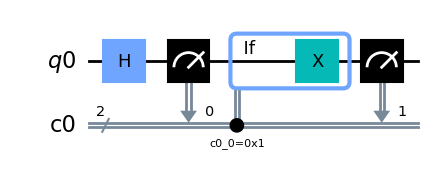

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister, ClassicalRegister

qr = QuantumRegister(1)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr, cr)

# unpack the qubit and classical bits from the registers
(q0,) = qr
b0, b1 = cr

# apply Hadamard
qc.h(q0)
# measure
qc.measure(q0, b0)

# begin if test block. the contents of the block are executed if b0 == 1
with qc.if_test((b0, 1)):
    # if the condition is satisfied (b0 == 1), then flip the bit back to 0
    qc.x(q0)
# finally, measure q0 again
qc.measure(q0, b1)

qc.draw(output="mpl", idle_wires=False)

양자 회로를 만들었으니 이 회로를 여러번 실행시키겠습니다. 첫번째 측정은 0 또는 1이 각각 절반의 확률로 나오겠지만 두번째 측정은 항상 0이 나오는 것을 확인하시길 바랍니다.

In [17]:
from qiskit_aer import AerSimulator

# initialize the simulator
backend_sim = AerSimulator()

# run the circuit
reset_sim_job = backend_sim.run(qc)
# get the results
reset_sim_result = reset_sim_job.result()
# retrieve the bitstring counts
reset_sim_counts = reset_sim_result.get_counts()

print(f"Counts: {reset_sim_counts}")

Counts: {'01': 512, '00': 512}


예상한 바와 같이 첫번째 측정 결과는 0 또는 1 모두 나올 수 있지만, 두번째 측정 결과는 0만 나옵니다. qiskit은 little-endian ordering을 사용한다는 것을 잊지 말기 바랍니다. 문자열 오른쪽이 첫번째 bit(`b0`)이고, 문자열 왼쪽이 두번째 bit(`b1`)입니다.

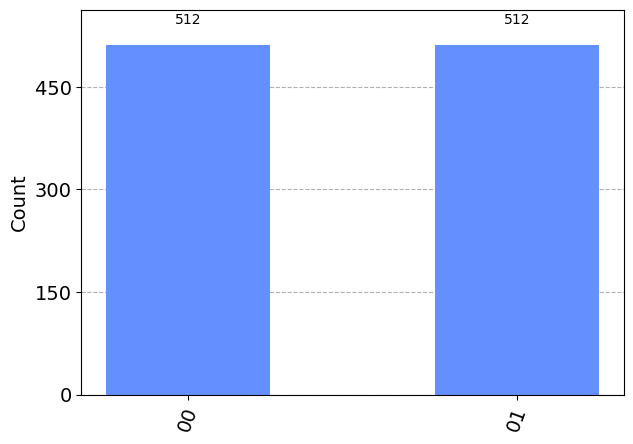

In [18]:
from qiskit.visualization import *

# plot histogram
plot_histogram(reset_sim_counts)

이제 여러분의 dynamic circuit을 만들어 가봅시다!

### 문제 1

앞의 예시보다는 조금 복잡한 것을 만들고자 합니다. 2 qubits와 2 classical bits를 가진 양자 회로를 만들고 `q0`의 관측 결과에 따라 `q1`에 가하는 gate를 다르게 할 것입니다. 여러분이 만드셔야 하는 회로에 대한 자세한 설명을 드리겠습니다.

만약 `q0` 관측 결과가 0 이라면 $X$ gate를 `q1`에 가하고, `q0` 관측 결과가 1 이라면 Hadamard gate를 `q1`에 가합니다.

`q0` 관측 결과에 무작위성을 부여하기 위하여 `q0`에 Hadamard gate를 먼저 가합니다. 그 후, `q0`의 관측 결과를 `b0`에 저장할 것입니다. 그 후 윗 문단에서 말한 _dynamic_ 조건에 기반하여 `q1`에 gate를 가하고 `q1`을 측정한 결과를 `b1`에 저장할 것입니다.

만약, `if_test()` 문을 작성하는 것에 어려움이 있으시다면 [링크](https://docs.quantum-computing.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#if_test-1)를 클릭하여 `if_test()` documentation을 참고하시길 바랍니다.

In [ ]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr, cr)

q0, q1 = qr
b0, b1 = cr

qc.h(q0)
qc.measure(q0, b0)


## Write your code below this line ## 




## Do not change the code below this line ##


qc.measure(q1, b1)
qc.draw(output="mpl", idle_wires=False)

아래에서 여러분이 만든 회로가 잘 작동하는지 확인할 수 있습니다.

어떠한 결과가 나와야 하는지 미리 생각해보고 아래의 코드 셀을 실행시키시길 바랍니다.

In [ ]:
backend_sim = AerSimulator()

job_1 = backend_sim.run(qc)
result_1 = job_1.result()
counts_1 = result_1.get_counts()

print(f"Counts: {counts_1}")

In [ ]:
# Grader Cell: Run this to submit your answer

from qc_grader.challenges.fall_fest23 import grade_ex3b

grade_ex3b(qc)

## Part 2: Repeat Until Success

양자 상태 측정 결과는 확률적으로 나오기 때문에 여러분이 원하는 결과가 나오지도 않을 때가 있습니다. 여러분이 만들고자 하는 알고리즘에 따라 중간에 측정을 했을 때 특정한 결과가 나와야지만 그 후에 연산을 해서 원하는 결과를 도출할 수 있는 경우도 있습니다. 대표적인 예시로는 HHL 알고리즘이 있습니다.

만약 여러분이 원하지 않은 결과과 중간 측정 때 나오면 어떻게 하실 것인가요? 음.. 다시 시도하면 됩니다! 여러분이 원하는 결과가 나올 확률이 0만 아니라면, 해당 과정을 계속 반복하다보면 결국 여러분이 원하는 결과가 나오게 될 것입니다.

보톧은 많은 반복을 하지 않아도 원하는 결과가 잘 나옵니다(이렇게 되도록 알고리즘을 만드는 것이 좋을 것입니다).

이번 파트에서는 "성공할 때까지 반복하기" 방법을 사용하여 $R_X(\theta)$ gate(이것이 무엇인지는 뒤에서 설명드리겠습니다)를 만들 것입니다. 여기서 여러분이 사용할 수 있는 gate들은 $\{H,\,X,\,S,\,\text{Toffoli}\}$ 이고, $\theta / \pi$가 무리수인 경우의 $R_X(\theta)$ gate를 구현해야합니다. 특히 여러분은 $\cos\theta = \frac35$에 해당하는 $\theta$ 만큼의 회전을 구현하시면 됩니다. 이것은 양자컴퓨팅 관련 대표 교재라고 할 수 있는 Nielsen and Chuang의 _Quantum Computation and Quantum Information_, 10<sup>th</sup> anniversary edition, Exercise 4.41 에서 다루는 universality of the finite gate set 내용과 관련되어 있다는 것을 말씀드립니다.

이것을 구현하기 위해서는 먼저 3개의 qubits가 필요합니다. 하나의 qubit은 "target" qubit이라고 부를 것이며, $R_X(\theta)$ gate가 가해지게 될 qubit 입니다. 다른 두개의 qubits는 "syndrome" qubit 이라고 부르며 이것을 측정하여 target qubit에 원하는 연산이 가해졌는지 여부를 판단하게 될 것입니다. 아래에서 여러분이 만들게 되는 회로에서는 만약 syndrome qubits를 측정했을 때 둘 다 $|0\rangle$상태로 측정이 된다면, target qubit에 원하는 연산이 가해진 것이고, 그렇지 않다면 qubits를 전부 reset 하고 다시 시작해야할 것입니다.

그럼 $R_X(\theta)$ gate 는 무엇일까요? 먼저 $R_X(\theta)$ gate의 수식을 보겠습니다.

$$R_X(\theta) = exp(-i\frac{\theta}{2}X) = \begin{bmatrix}\cos(\frac{\theta}{2})&-i\sin(\frac{\theta}{2})\\-i\sin(\frac{\theta}{2})&\cos(\frac{\theta}{2})\\ \end{bmatrix}$$

이와 같은 single qubit 연산입니다. 이것이 의미하는 것은 bloch sphere 상에서 양자 상태를 X축을 중심으로 $\theta$만큼 회전시키는 연산입니다. 아래에서 그 예시를 보겠습니다.

초기 상태


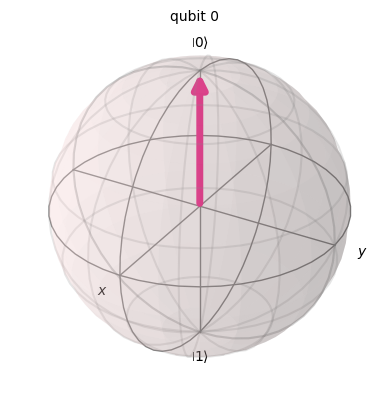


 X축을 기준으로 양의 방향으로 30도 회전


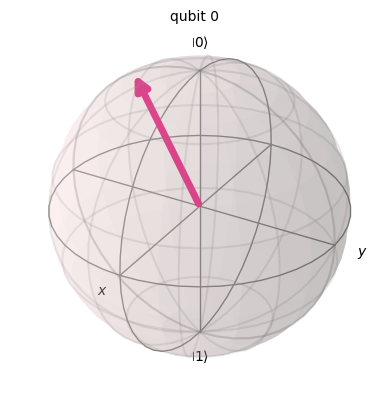


 X축을 기준으로 음의 방향으로 30도 회전


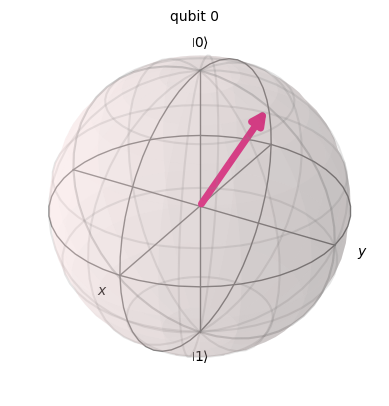


 X축을 기준으로 양의 방향으로 90도 회전


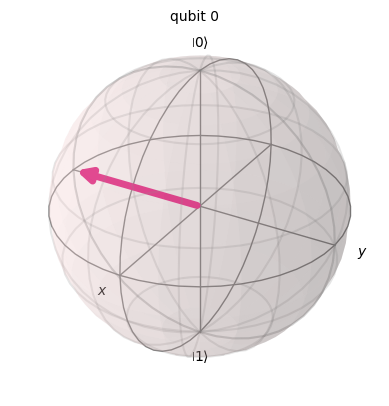

In [12]:
from qiskit.visualization import plot_bloch_multivector
import numpy as np

qc = QuantumCircuit(1)
print("초기 상태")
display(plot_bloch_multivector(qc))

print("\n X축을 기준으로 양의 방향으로 30도 회전") #30도는 radian으로 π/6
qc = QuantumCircuit(1)
qc.rx(np.pi/6, 0)
display(plot_bloch_multivector(qc))

print("\n X축을 기준으로 음의 방향으로 30도 회전") #30도는 radian으로 π/6
qc = QuantumCircuit(1)
qc.rx(-np.pi/6, 0)
display(plot_bloch_multivector(qc))

print("\n X축을 기준으로 양의 방향으로 90도 회전") #90도는 radian으로 π/2
qc = QuantumCircuit(1)
qc.rx(np.pi/2, 0)
display(plot_bloch_multivector(qc))

이제 두번째 문제 시작하겠습니다!

### 문제 2

여러분이 가장 먼저 해야할 작업은 아래의 그림과 같은 양자 회로를 만들어주는 함수를 작성하는 것입니다.

<center>
<img src="images/circuitRx.png">
</center>